In [66]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
import scipy
import matplotlib.patches as patches
import pandas as pd
from scipy.io import readsav
from regions import Regions #read_ds9, write_ds9
import csv
import math
from scipy.optimize import curve_fit
import time
from pathlib import Path
from pyds9 import ds9
from scipy.integrate import quad
from astropy.table import QTable, Table, Column, vstack
from astropy.visualization.stretch import AsinhStretch
from astropy.visualization import ImageNormalize, simple_norm
import matplotlib.patches as patches
import pymc as pm
import arviz as az

In [2]:
hdr = fits.getheader('ISF_Mosaic_Trial5_drz_sci.fits')
im  = fits.getdata('ISF_Mosaic_Trial5_drz_sci.fits')
wcs = WCS(hdr)

In [3]:
def write_regf(ra, dec, fname, c, text, r=None, update=False):
    """
    fname - file name to be written
    c - region color
    """
    xx, yy = ra, dec
    text = np.array(text, dtype=str)
    if r==None:
        r =25
    else:
        r=r
    if update == True:
        with open(fname) as unt:
            lines = unt.readlines()
        with open(fname, 'w') as unt:    
            unt.writelines(lines)

            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')
    else:
        with open(fname, 'w') as unt:
            unt.write('fk5')
            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')

In [4]:
def norm_logistic_reg(x, mu, sig):
    w = 1/(1+np.exp(-((x-mu)/sig)))
    return w

def r_times_logistic_reg(x, m, s):
    w = x/(1+np.exp(-((x-m)/s)))
    return w

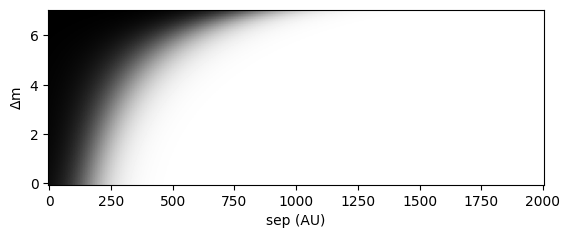

In [5]:
frac_mtx = np.loadtxt('Fraction_dm_sep_array.txt')
fig, ax = plt.subplots()
plt.imshow(frac_mtx, origin='lower', cmap='gray')
plt.xticks(np.arange(0, 201, 25), np.arange(0, 2001, 250))
plt.yticks(np.arange(0, 70, 20), np.arange(0, 7, 2))
plt.xlabel('sep (AU)')
plt.ylabel('$\Delta$m');

In [6]:
df_params = pd.read_csv('mu_sig_params.csv')
mu, sig = np.array(df_params['mu']), np.array(df_params['sig'])
df_flame = pd.read_csv('dm_sep_flame.csv')
sep_flame, dm_flame = np.array(df_flame['sep']), np.array(df_flame['dm'])

In [7]:
df_final = pd.read_csv('dash_rereduce_removed_combined_with_rereduceII_with_VISION.csv')
df_final2 = df_final
ra_f2 = np.array(df_final2['RA_d'])
dec_f2 = np.array(df_final2['DEC_d'])
m_f2 = np.array(df_final2['MAG_d'])
me_f2 = np.array(df_final2['MAG_d_unc'])
h_f2 = np.array(df_final2['H_v'])
he_f2 = np.array(df_final2['He_v'])
k_f2 = np.array(df_final2['Ks_v'])
ke_f2 = np.array(df_final2['Kse_v'])
fwhm_f2 = np.array(df_final2['FWHM_d'])
rsat_f2 = np.array(df_final2['R_SAT_d'])
clas_f2 = np.array(df_final2['class'], dtype=str)

yso_clas = np.array(['protostars', 'disks', 'td', 'nd_proto_faint'])
proto_clas = np.array(['protostars', 'nd_proto_faint'])
prems_clas = np.array(['disks', 'td'])

i_yso, = np.where(np.isin(clas_f2, yso_clas))
i_proto, = np.where(np.isin(clas_f2, proto_clas))
i_prems, = np.where(np.isin(clas_f2, prems_clas))

In [8]:
write_regf(ra_f2[np.isfinite(ra_f2)], dec_f2[np.isfinite(ra_f2)], 'Final_Catalog.reg', 'green', [])

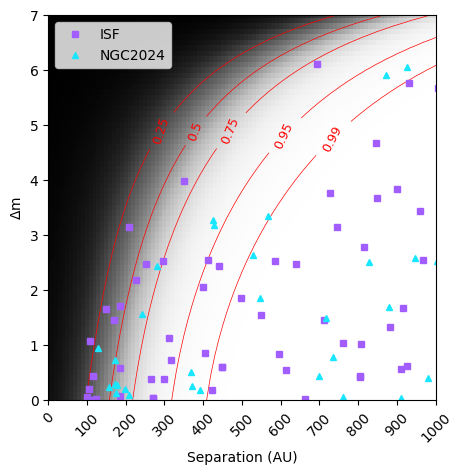

In [9]:
dms = np.arange(0, 7.01, 1/10)
seps = np.arange(0, 2001., 100/10)
dm_mtx, sep_mtx = np.indices((len(dms), len(seps)))
#sep_mtx = np.tile(np.arange(0, 2000.1, 0.1), )
dm_mtx, sep_mtx = (np.flip(dm_mtx,0))/10, 100*(sep_mtx+5)/10
frac_mtx = np.zeros(dm_mtx.shape)
n_dm = len(dms)
for i in range(len(mu)):
    frac_mtx[i, :] =  norm_logistic_reg(seps, mu[i], sig[i])
    
cmap = plt.cm.cool
category_colors = plt.colormaps['cool'](np.linspace(0.10, 0.85, 8))

fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(frac_mtx, origin='lower', cmap='Greys_r', aspect="auto")


c25 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.25], colors='r', alpha=0.99, linewidths=0.5)
c50 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.50], colors='r', alpha=0.99, linewidths=0.5)
c75 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.75], colors='r', alpha=0.99, linewidths=0.5)
c95 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.95], colors='r', alpha=0.99, linewidths=0.5)
c99 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.99], colors='r', alpha=0.99, linewidths=0.5)

xt = ax.get_xticks()
#ax.set_xticks(xt[1::], np.round(xt[1::]*100/10).astype(int))
ax.set_xticks(np.arange(0, 201, 10), np.arange(0, 2001, 100), rotation=45)
yt = ax.get_yticks()
ax.set_yticks(yt[1:-1], np.round((yt[1:-1])/10).astype(int))


manual_locations = [(20, 50)]
plt.clabel(c25, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(30, 50)]
plt.clabel(c50, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(40, 50)]
plt.clabel(c75, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(50, 50)]
plt.clabel(c95, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(60, 50)]
plt.clabel(c99, fontsize=9, inline=1, manual=manual_locations)

ax.set_xlabel('Separation (AU)')
ax.set_ylabel('$\Delta$m')


ra_cat, dec_cat, m_cat, i_yso = ra_f2, dec_f2, m_f2, i_yso
N_total = len(i_yso)
N_cand, N_cont = 0, 0
r1_comp = 100
r2_comp = 2000
r1_cont = 2000
r2_cont = 5000

#Making a catalog object using all sources
c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
              distance=400.*u.pc, frame='fk5')

ra_yso  = ra_cat[i_yso]
dec_yso = dec_cat[i_yso]
m_yso   = m_cat[i_yso]

i_tested = np.array([])
N_cand   = np.array([])

d_comp = np.array([])
dm_comp = np.array([])
r_comp = np.array([])
dc_comp = np.array([])
mag_prim = np.array([])

for i in range(N_total):
    #Making a catalog object using YSO
    c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
    sep_     = c2.separation(c1).arcsec*400.
    i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp)&(m_cat>10.5))
    n_obj    = len(i_obj_)

    if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.)&(m_yso[i]>12.):
        ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
        dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
        m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array

        i_prim, = np.where(m_sys==np.min(m_sys))
        i_comp, = np.where(m_sys!=np.min(m_sys))
        N_cand  = N_cand + len(i_comp)
        ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
        ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
        m_prim = m_sys[i_prim]
        c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')

        c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
        sep_comp = c_comp.separation(c_prim).arcsec*400.
        #ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
        d_comp = np.append(d_comp, sep_comp)
        dm_comp = np.append(dm_comp, np.abs((m_sys[i_comp]-m_prim)))
        r_comp, dc_comp = np.append(r_comp, ra_comp), np.append(dc_comp, dec_comp)
        mag_prim = np.append(mag_prim, np.ones(ra_comp.shape)*m_prim[0])
ax.plot(d_comp/10, dm_comp*10, 's', c=category_colors[5], ms=4, label='ISF')
ax.plot(sep_flame/10, dm_flame*10, '^', c=category_colors[0], ms=4, label='NGC2024')

ax.set_yticks(np.arange(0, 71, 10), np.arange(0, 8, 1))
ax.set_ylim(0, 70)

ax.set_xlim(0, 100)
ax.legend()
plt.savefig('delmag_sep_with_contours.pdf', bbox_inches='tight')

In [10]:
contours = [c25, c50, c75, c95, c99]
percentages = ['25', '50', '75', '95', '99']
for i in range(len(contours)):
    print(str(percentages[i]), contours[i].collections[0].get_paths()[1].vertices[-1][0]*10)


25 97.79256713263882
50 157.91757427791288
75 218.03999920591116
95 318.9396992160144
99 409.1550819950012


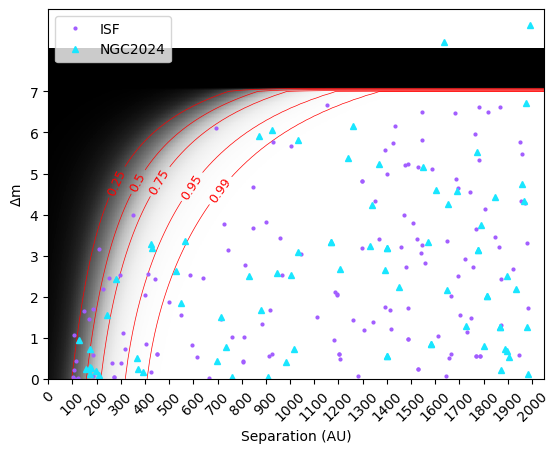

In [11]:
dms = np.arange(0, 8.01, 1/10)
seps = np.arange(0, 2051., 100/10)
dm_mtx, sep_mtx = np.indices((len(dms), len(seps)))
#sep_mtx = np.tile(np.arange(0, 2000.1, 0.1), )
dm_mtx, sep_mtx = (np.flip(dm_mtx,0))/10, 100*(sep_mtx+5)/10
frac_mtx = np.zeros(dm_mtx.shape)
n_dm = len(dms)
for i in range(len(mu)):
    frac_mtx[i, :] =  norm_logistic_reg(seps, mu[i], sig[i])
    
cmap = plt.cm.cool
category_colors = plt.colormaps['cool'](np.linspace(0.10, 0.85, 8))

fig, ax = plt.subplots()
plt.imshow(frac_mtx, origin='lower', cmap='Greys_r', aspect="auto")


c25 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.25], colors='r', alpha=0.99, linewidths=0.5)
c50 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.50], colors='r', alpha=0.99, linewidths=0.5)
c75 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.75], colors='r', alpha=0.99, linewidths=0.5)
c95 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.95], colors='r', alpha=0.99, linewidths=0.5)
c99 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.99], colors='r', alpha=0.99, linewidths=0.5)

xt = ax.get_xticks()
#ax.set_xticks(xt[1::], np.round(xt[1::]*100/10).astype(int))
ax.set_xticks(np.arange(0, 201, 10), np.arange(0, 2001, 100), rotation=45)
yt = ax.get_yticks()
ax.set_yticks(yt[1:-1], np.round((yt[1:-1])/10).astype(int))


manual_locations = [(20, 50)]
plt.clabel(c25, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(30, 50)]
plt.clabel(c50, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(40, 50)]
plt.clabel(c75, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(50, 50)]
plt.clabel(c95, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(60, 50)]
plt.clabel(c99, fontsize=9, inline=1, manual=manual_locations)

ax.set_xlabel('Separation (AU)')
ax.set_ylabel('$\Delta$m')


ra_cat, dec_cat, m_cat, i_yso = ra_f2, dec_f2, m_f2, i_yso
N_total = len(i_yso)
N_cand, N_cont = 0, 0
r1_comp = 100
r2_comp = 2000
r1_cont = 2000
r2_cont = 5000

#Making a catalog object using all sources
c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
              distance=400.*u.pc, frame='fk5')

ra_yso  = ra_cat[i_yso]
dec_yso = dec_cat[i_yso]
m_yso   = m_cat[i_yso]

i_tested = np.array([])
N_cand   = np.array([])

d_comp = np.array([])
dm_comp = np.array([])
r_comp = np.array([])
dc_comp = np.array([])
mag_prim = np.array([])

for i in range(N_total):
    #Making a catalog object using YSO
    c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
    sep_     = c2.separation(c1).arcsec*400.
    i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp)&(m_cat>10.5))
    n_obj    = len(i_obj_)

    if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.)&(m_yso[i]>12.):
        
        i_prim, = np.where(m_sys==np.min(m_sys))
        i_comp, = np.where(m_sys!=np.min(m_sys))
        #i_comp,  = np.where((np.abs(m_sys[i_comp])-m_sys[i_prim])<=7.0)
        #if len(i_comp)>0.:
        #i_comp,  = np.where((np.abs(m_comp)-m_prim)<=14.0)
        #if len(i_comp):
            

        m_prim = m_sys[i_prim]
        m_comp = m_sys[i_comp]

        if np.abs(m_comp - m_prim).any() <= 7.0:
            i_comp = i_comp[np.abs(m_comp - m_prim)<=7.0]
            m_comp = m_sys[i_comp]

            N_cand  = N_cand + len(m_comp)
            ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
            ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
            dm_comp = np.append(dm_comp, np.abs((m_comp - m_prim)))


            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array

            c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')

            c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
            sep_comp = c_comp.separation(c_prim).arcsec*400.
            d_comp = np.append(d_comp, sep_comp)

            r_comp, dc_comp = np.append(r_comp, ra_comp), np.append(dc_comp, dec_comp)
            mag_prim = np.append(mag_prim, np.ones(ra_comp.shape)*m_prim[0])
ax.plot(d_comp/10, dm_comp*10, '.', c=category_colors[5], ms=4, label='ISF')
ax.plot(sep_flame/10, dm_flame*10, '^', c=category_colors[0], ms=4, label='NGC2024')
#ax.set_ylim(0, 100)
#ax.set_yticks(np.arange(0, 11, 1))
#yticks = ax.get_yticks()

ax.set_yticks(np.arange(0, 71, 10), np.arange(0, 8, 1))
ax.set_ylim(0, 90)

ax.set_xlim(0, 205)
ax.legend()

In [12]:
r_comp[dm_comp*10>70], dc_comp[dm_comp*10>70], mag_prim[dm_comp*10>70], dm_comp[dm_comp*10>70]

(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

In [13]:
i_comp,  = np.argwhere(~np.isnan((np.abs(m_comp)-m_prim)<=7.0))
if len(i_comp):
    print(i_comp)
(np.abs(m_comp)-m_prim)<=7.0

[0]


array([ True])

In [14]:
#
def CF(ra_cat, dec_cat, m_cat, i_yso):
    N_total = len(i_yso) #Total number of YSOs
    N_cand, N_cont, N_comp = 0, 0, 0
    
    r1_comp = 100
    r2_comp = 1000
    r1_cont = 2000
    r2_cont = 5000
    
    bw = 100
    bins = (np.zeros((len(i_yso), len(np.arange(1, 5000/bw+1, 1)))))
    bin_count = np.arange(1, 5000/bw+1, 1, dtype=int)

    def r_times_logistic_reg(x, m, s):
        w = x*1/(1+np.exp(-((x-m)/s)))
        return w
    
    
    #Making a catalog object using all sources
    c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
                  distance=400.*u.pc, frame='fk5')
   
    ra_yso  = ra_cat[i_yso]
    dec_yso = dec_cat[i_yso]
    m_yso   = m_cat[i_yso]
    
    i_tested = np.array([])

    R     = np.array([])
    R_unc = np.array([])
    N_cont_init = np.array([])
    N_cont_corr = np.array([])
    N_cont_prior_corr = np.array([])
    N_cont  = 0
    d_mag   = np.array([])
    dist    = np.array([])
    cont_m  = np.array([])
    #fig, ax = plt.subplots()
    
    for i in range(N_total):
        
        
        #Making a catalog object using the ith YSO
        c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
        sep_     = c2.separation(c1).arcsec*400.
        i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp))#&(m_cat>10.5))
        n_obj    = len(i_obj_)
        i_cont,  = np.where((sep>=r1_cont)&(sep<=r2_cont))
        
        for i_bin in bin_count:
            i_obj_bin,  = np.where((sep_>=i_bin*bw)&(sep_<=(i_bin*bw+bw)))
            bins[i,i_bin-1] = np.sum(i_obj_bin)
                                 
        if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array
            if len(i_tested)==0:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=False)
            else:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=True)
            
            
            i_prim, = np.where(m_sys==np.min(m_sys))
            i_comp, = np.where(m_sys!=np.min(m_sys))
            
            m_prim = m_sys[i_prim]
            m_comp = m_sys[i_comp]
            
            if np.abs(m_comp - m_prim).any() <= 7.0:
                i_comp = i_comp[np.abs(m_comp - m_prim)<=7.0]
                m_comp = m_sys[i_comp]

                ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
                ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]

                c_comp   = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')
                c_prim   = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
                sep_comp = c_comp.separation(c_prim).arcsec*400.

                #making a new cat obj with the dimmest objects in the system
                #n_obj is recalculated using the "new" primary.
                sep      = c2.separation(c_prim).arcsec*400.
                i_obj_,  = np.where((sep>=r1_comp)&(sep<=r2_comp))#&(m_cat>10.5))
                n_obj    = len(i_obj_)
                N_cand   = N_cand + n_obj
                i_cont,  = np.where((sep>=r1_cont)&(sep<=r2_cont))
                
        else:
            m_prim   = m_yso[i]
            i_cont,  = np.where((sep_>=r1_cont)&(sep_<=r2_cont))
        
        N_cont_init = np.append(N_cont_init, len(i_cont))
        n_cont      = 0
        if len(i_cont)>0: #N_contaminants is calculated around all YSOs in the region.
            for j in range(len(i_cont)):
                delta_m = m_cat[i_cont[j]]-m_prim
                cont_m = np.append(cont_m, m_cat[i_cont[j]])
                dm_int  = int(np.abs(10*np.round(delta_m, 1)))
                if dm_int>70: #80: delta_mag=8
                    mu_, sig_ = 0, 0
                    R_ = 0
                else:
                    mu_  = mu[dm_int]
                    sig_ = sig[dm_int]
                    I  = quad(r_times_logistic_reg, r1_comp, r2_comp, args=(mu_, sig_))
                    R_ = 2*np.pi * I[0] / (np.pi*(r2_cont**2 - r1_cont**2))
                    R  = np.append(R, R_)
                    d_mag=np.append(d_mag,dm_int)
                    R_unc   = np.append(R_unc, I[1])
                    dist = np.append(dist, sep_[i_cont[j]])
                n_cont  = n_cont + R_
                
            N_cont_corr = np.append(N_cont_corr, n_cont)
            N_cont_prior_corr = np.append(N_cont_prior_corr, 
                                          len(i_cont)*
                                          (r2_comp**2-r1_comp**2)/(r2_cont**2-r1_cont**2))
            N_cont = N_cont + n_cont

        
            
        i_tested = np.append(i_tested, i_yso[i])
        i_tested = np.append(i_tested, i_obj_)
        
        
        
    N_comp   = N_cand - N_cont
        

    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.85, 5))
    #for i in range(len(dist)):
    #    ax.plot(dist[i], d_mag[i], '.', color=category_colors[int(100*np.round(R[i], 3))])           
    #ax.plot(R, '.r')
    print('N_cand: ', N_cand)
    print('N_cont within 200-5000 (before correction): ', np.sum(N_cont_prior_corr))
    print('N_cont within 200-5000: ', np.sum(N_cont_corr))
    print('N_contaminants: ', np.sum(N_cont_init))
    print('N_comp: ', N_comp)
    print('CF ('+str(N_total)+'): ', N_comp/N_total)
    return d_mag, R, dist, cont_m, bins, bin_count

In [46]:
def CF(ra_cat, dec_cat, m_cat, i_yso):
    N_total = len(i_yso) #Total number of YSOs
    N_cand, N_cont, N_comp = 0, 0, 0
    
    r1_comp = 100
    r2_comp = 1000
    r1_cont = 2000
    r2_cont = 5000
    
    bw = 100
    bins = (np.zeros((len(i_yso), len(np.arange(1, 5000/bw+1, 1)))))
    bin_count = np.arange(1, 5000/bw+1, 1, dtype=int)

    def r_times_logistic_reg(x, m, s):
        w = x*1/(1+np.exp(-((x-m)/s)))
        return w
    
    
    #Making a catalog object using all sources
    c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
                  distance=400.*u.pc, frame='fk5')
   
    ra_yso  = ra_cat[i_yso]
    dec_yso = dec_cat[i_yso]
    m_yso   = m_cat[i_yso]
    
    i_tested = np.array([])

    R     = np.array([])
    R_unc = np.array([])
    N_cont_init = np.array([])
    N_cont_corr = np.array([])
    N_cont_prior_corr = np.array([])
    N_cont  = 0
    d_mag   = np.array([])
    dist    = np.array([])
    cont_m  = np.array([])
    #fig, ax = plt.subplots()
    
    for i in range(N_total):
        
        
        #Making a catalog object using the ith YSO
        c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
        sep_     = c2.separation(c1).arcsec*400.
        i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp))#&(m_cat>10.5))
        n_obj    = len(i_obj_)
        
        for i_bin in bin_count:
            i_obj_bin,  = np.where((sep_>=i_bin*bw)&(sep_<=(i_bin*bw+bw)))
            bins[i,i_bin-1] = np.sum(i_obj_bin)
                                 
        if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array
            if len(i_tested)==0:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=False)
            else:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=True)
            
            
            i_prim, = np.where(m_sys==np.min(m_sys))
            i_comp, = np.where(m_sys!=np.min(m_sys))
            
            m_prim = m_sys[i_prim]
            m_comp = m_sys[i_comp]
            
            if np.abs(m_comp - m_prim).any() <= 7.0:
                i_comp = i_comp[np.abs(m_comp - m_prim)<=7.0]
                m_comp = m_sys[i_comp]

                ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
                ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]

                c_comp   = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')
                c_prim   = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
                sep_comp = c_comp.separation(c_prim).arcsec*400.

                #making a new cat obj with the dimmest objects in the system
                #n_obj is recalculated using the "new" primary.
                sep      = c2.separation(c_prim).arcsec*400.
                i_obj_,  = np.where((sep>=r1_comp)&(sep<=r2_comp))#&(m_cat>10.5))
                n_obj    = len(i_obj_)
                N_cand   = N_cand + n_obj
                i_cont,  = np.where((sep>=r1_cont)&(sep<=r2_cont))
                
        else:
            m_prim   = m_yso[i]
            i_cont,  = np.where((sep_>=r1_cont)&(sep_<=r2_cont))
        
        N_cont_init = np.append(N_cont_init, len(i_cont))
        n_cont      = 0
        if len(i_cont)>0: #N_contaminants is calculated around all YSOs in the region.
            for j in range(len(i_cont)):
                delta_m = m_cat[i_cont[j]]-m_prim
                cont_m = np.append(cont_m, m_cat[i_cont[j]])
                dm_int  = int(np.abs(10*np.round(delta_m, 1)))
                if dm_int>70: #80: delta_mag=8
                    mu_, sig_ = 0, 0
                    R_ = 0
                else:
                    mu_  = mu[dm_int]
                    sig_ = sig[dm_int]
                    I  = quad(r_times_logistic_reg, r1_comp, r2_comp, args=(mu_, sig_))
                    R_ = 2*np.pi * I[0] / (np.pi*(r2_cont**2 - r1_cont**2))
                    R  = np.append(R, R_)
                    d_mag=np.append(d_mag,dm_int)
                    R_unc   = np.append(R_unc, I[1])
                    dist = np.append(dist, sep_[i_cont[j]])
                n_cont  = n_cont + R_
                
            N_cont_corr = np.append(N_cont_corr, n_cont)
            N_cont_prior_corr = np.append(N_cont_prior_corr, 
                                          len(i_cont)*
                                          (r2_comp**2-r1_comp**2)/(r2_cont**2-r1_cont**2))
            N_cont = N_cont + n_cont

        
            
        i_tested = np.append(i_tested, i_yso[i])
        i_tested = np.append(i_tested, i_obj_)
        
        
        
    N_comp   = N_cand - N_cont
        

    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.85, 5))
    #for i in range(len(dist)):
    #    ax.plot(dist[i], d_mag[i], '.', color=category_colors[int(100*np.round(R[i], 3))])           
    #ax.plot(R, '.r')
    print('N_cand: ', N_cand)
    print('N_cont within 200-5000 (before correction): ', np.sum(N_cont_prior_corr))
    print('N_cont within 200-5000: ', np.sum(N_cont_corr))
    print('N_contaminants: ', np.sum(N_cont_init))
    print('N_comp: ', N_comp)
    print('CF ('+str(N_total)+'): ', N_comp/N_total)
    return d_mag, R, dist, cont_m, bins, bin_count

In [16]:
type(ra_f2), type(m_f2), type(i_yso)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [48]:
dmag, R, dist, cmag, sig_bins, bin_count,  = CF(ra_f2, dec_f2, m_f2, i_yso)

N_cand:  92
N_cont within 200-5000 (before correction):  40.307142857142864
N_cont within 200-5000:  32.34704739197906
N_contaminants:  855.0
N_comp:  59.65295260802091
CF (671):  0.0889015687153814


In [49]:
bin_radii = bin_count*bw
bin_areas = np.pi*((bin_radii)**2-(bin_radii-bw)**2)
bin_mean = np.mean(sig_bins, axis=0)/bin_areas

## $P(f | \phi)$

In [54]:
# Draw samples for one variable
with pm.Model():
    x = pm.Poisson("hist_try", )
x_draws = pm.draw(x, draws=100)
print(x_draws.shape)

(100,)


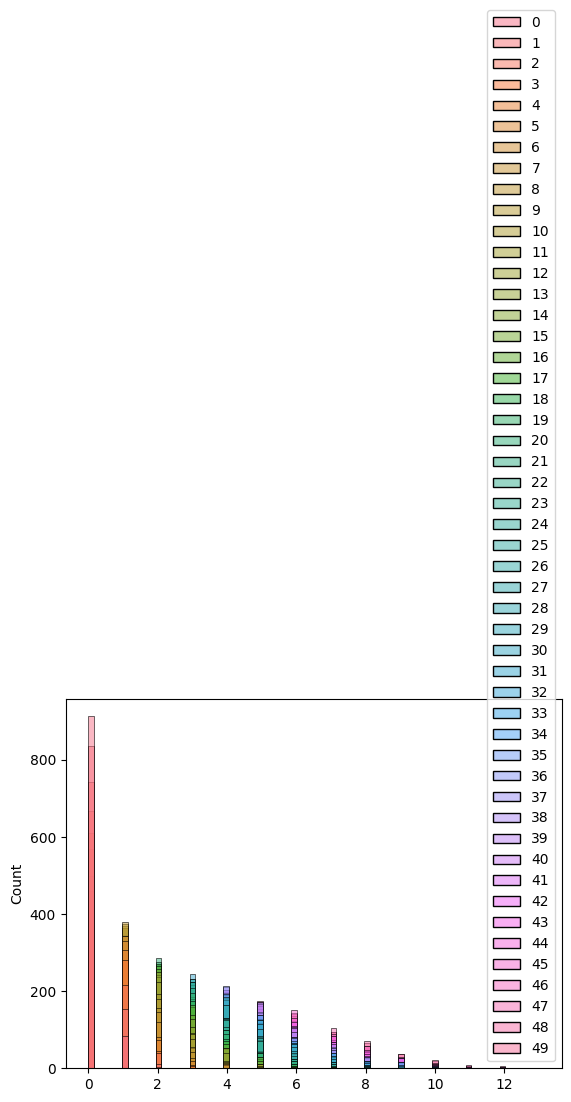

In [53]:
#x = pm.Gamma.dist(alpha=2, beta=1)
x_draws = pm.draw(hist_try, draws=1000)
sns.histplot(x_draws);

In [33]:
import seaborn as sns

In [ ]:
SEED = 845199

SAMPLE_KWARGS = {"chains": 4, "tune": 1000, 
                 "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}
Pf_model      = pm.Model()

with Pf_model:
    
    y_obs     = pm.Poisson("P_f", mu=0, observed=bin_mean)
    Pf_trace  = pm.sample(**SAMPLE_KWARGS)
    Pf_forecast = pm.sample_posterior_predictive(Pf_trace, var_names=["P_f"])

In [78]:
pm.Poisson('pois_hist', mu=0.5).dist(x)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

In [202]:
from scipy.stats import poisson, logistic

In [200]:
help(logistic.)

Help on function logistic in module __main__:

logistic(x, a)
    #interpolated = pm.Interpolated.dist(np.arange(0, 8, 1), )



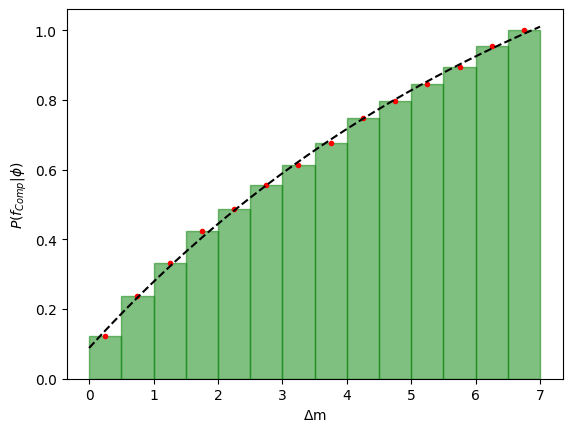

In [19]:
plt.subplot()
bw=100
n, bins, patches = plt.hist(dmag/10, bins=np.arange(0, 7.051, 0.5),
                            density = True, log=False, cumulative=True,
                           color='green', alpha=0.5, edgecolor='g')
#plt.plot(bins[0:-1]+0.05, n, '.r')
plt.xlabel('$\Delta$m')
plt.ylabel('$P(f_{Comp}|\phi)$')

#interpolated = pm.Interpolated.dist(np.arange(0, 8, 1), )
def parabola(x, a, b, c):
    return a - b*np.exp(-c*(x))
plt.plot(bins[0:-1]+0.25, n, '.r')
popt, pcov = curve_fit(parabola, bins[0:-1]+0.25, n, p0=[1, 1, 1])
#mu = popt

x = np.arange(0, 7.00001, 0.01)
plt.plot(x, parabola(x, *popt), 'k--', ms=1)
#plt.plot(x, scipy.stats.poisson(mu).ppf(x), '+k')

In [265]:
parabola(0, *popt)

0.08812595439886861

##### other

In [251]:
SEED = 845199

SAMPLE_KWARGS = {"chains": 4, "tune": 1000, 
                 "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}

with pm.Model() as Pf_model:
    prob = pm.Interpolated('P_f', bins[0:-1], n)
    Pf_trace = pm.sample(**SAMPLE_KWARGS)
    Pf_forecast = pm.sample_posterior_predictive(Pf_trace, var_names=["P_f"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [P_f]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [P_f]


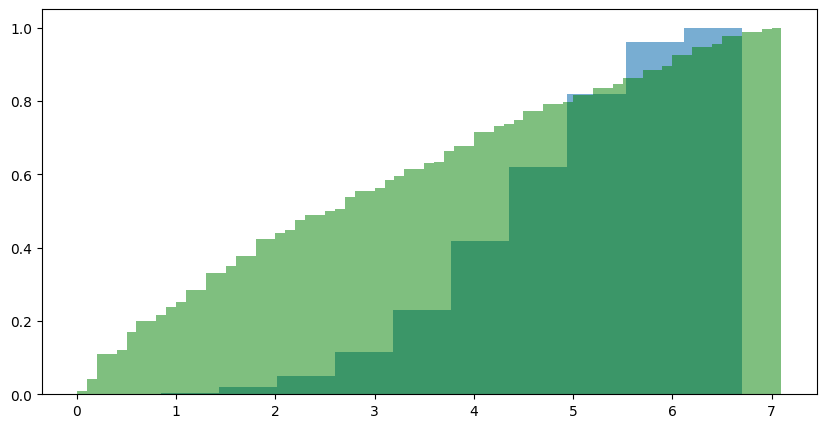

In [254]:
post_pred_Pf = Pf_forecast.posterior_predictive['P_f'].data

P_f = np.median(post_pred_Pf, axis=0)
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(P_f, alpha=0.6, density=True, cumulative=True)
plt.hist(dmag/10, bins=np.arange(0, 7.1001, 0.1),
                            density = True, cumulative=True, 
                           color='green', alpha=0.5);

In [63]:
post_pred_Pf = Pf_forecast.posterior_predictive['P_f']
post_pred_Pf.data.shape

(4, 1000)

## $P(\Sigma_{los} | N_{cont})= \frac{(\Sigma_{los}\Omega_{cont})^{N_{cont}}}{N_{cont}!}e^{-\Sigma_{los}\Omega_{cont}}$

$N_{cont} \sim Poisson()$

$P(\Sigma_{los} | N_{cont}) \sim Gamma()$

In [99]:
SEED = 845199

SAMPLE_KWARGS = {"chains": 4, "tune": 1000, 
                 "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}
Pz_model      = pm.Model()

with Pz_model:
    N_cont    = pm.Poisson('N_cont', mu=855.) #alpha
    O_cont    = np.pi*(5000**2 - 2000**2)
    y_obs     = pm.Gamma("P_z", alpha=N_cont, beta=O_cont, observed=bin_mean)
    Pz_trace  = pm.sample(**SAMPLE_KWARGS)
    Pz_forecast = pm.sample_posterior_predictive(Pz_trace, var_names=["P_z", 'N_cont'])

Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [N_cont]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [N_cont, P_z]


Text(0.5, 0, 'Separation (AU)')

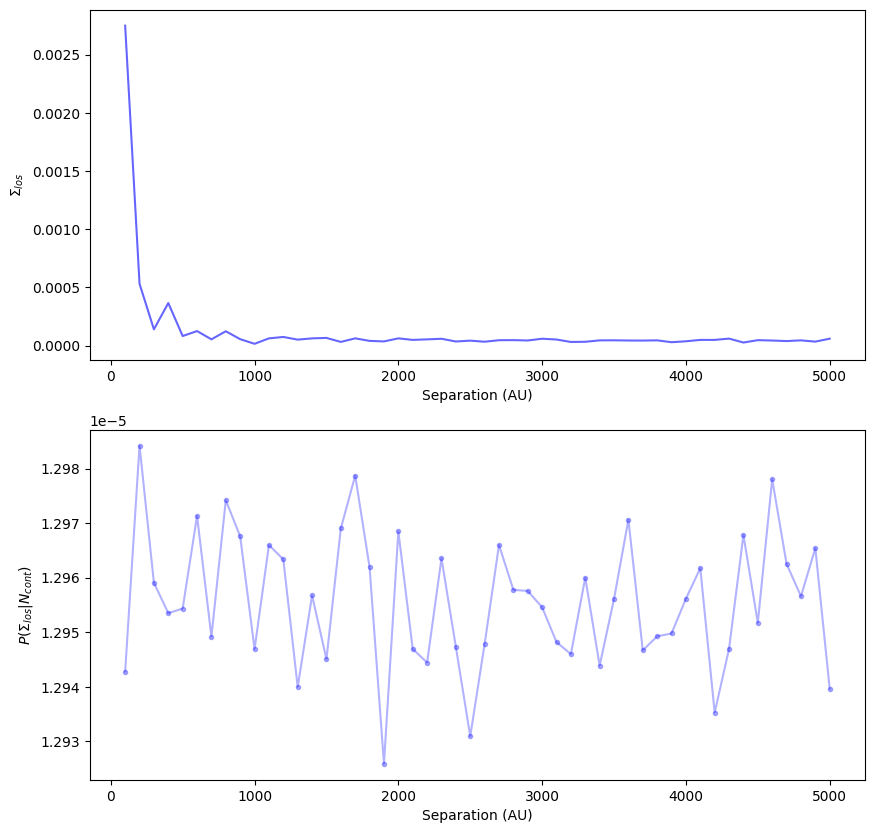

In [56]:
post_pred = Pz_forecast.posterior_predictive['P_z'].data
P_zlos = np.median(np.median(post_pred['P_z'], axis=0), axis=0)
fig, ax = plt.subplots(2,1,figsize=(10, 10))
p1 = ax[0].plot(bin_count*bw, bin_mean, 'b', alpha=0.6)
ax[0].set_ylabel('$\Sigma_{los}$')
ax[0].set_xlabel('Separation (AU)')
ax[1].plot(bin_count*bw, P_zlos, '.b', alpha=0.3)
ax[1].plot(bin_count*bw, P_zlos, '-b', alpha=0.3)
ax[1].set_ylabel('$P(\Sigma_{los}|N_{cont})$')
ax[1].set_xlabel('Separation (AU)')

## $P(N_{comp} | N_{cand},\Sigma_{los}, f) = \frac{(\Sigma_{los}\Omega_{cand})^{(N_{cand}-N_{comp})}}{(N_{cand}-N_{comp})!}e^{-\Sigma_{los}\Omega_{cand}}$

In [102]:
N_yso = 671

In [103]:
SEED = 845199

SAMPLE_KWARGS = {"chains": 4, "tune": 1000, 
                 "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}
Pc_model      = pm.Model()

with Pc_model:
    O_cand    = np.pi*(1000**2 - 100**2)
    O_cont    = np.pi*(5000**2 - 2000**2)
    #N_comp    = pm.Poisson('N_comp',  mu=59.65295)
    y_obs     = pm.Poisson("P_NSig", mu=N_yso/O_cont*O_cand, observed=True)
    Pc_trace  = pm.sample(**SAMPLE_KWARGS)
    Pc_forecast = pm.sample_posterior_predictive(Pc_trace, 
                                                 var_names=["P_NSig"])

Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [N_comp]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
Sampling: [P_NSig]


In [96]:
n_cand, n_comp = 92, 59.65295
np.math.factorial(n_cand-n_comp)

/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_93443/415061442.py:2: DeprecationWarning: Using factorial() with floats is deprecated
  np.math.factorial(n_cand-n_comp)


ValueError: factorial() only accepts integral values

In [106]:
N_comp

N_comp ~ Poisson(59.7)

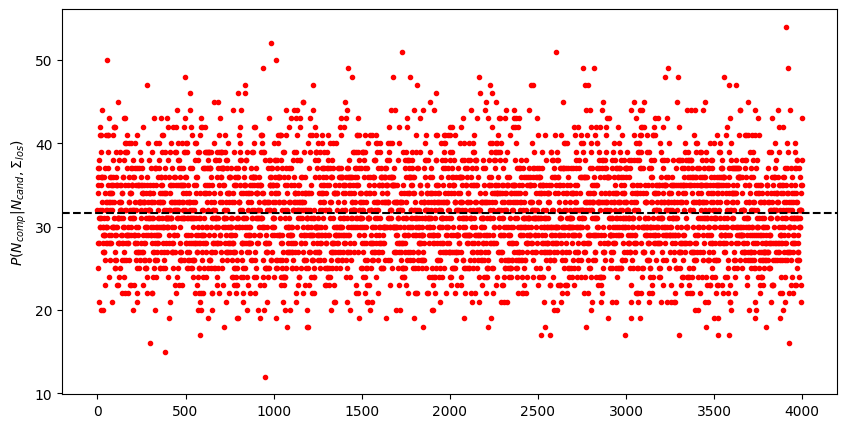

In [114]:
post_pred = Pc_forecast.posterior_predictive['P_NSig'].data
P_NSig = np.median(np.median(post_pred, axis=0), axis=0)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('$P(N_{comp}|N_{cand}, \Sigma_{los})$')
#ax.set_xlabel('Separation (AU)')
#ax.plot(P_NSig, '.r', alpha=0.3)
#ax.plot(P_Ncomp, '-r', alpha=0.3)
#ax.plot((bin_mean*O_cand)**(N_cand-N_comp)/np.math.factorial(N_cand-N_comp))
ax.plot(post_pred.flatten(), '.r')
ax.axhline(N_yso/O_cont*O_cand, c='k', ls='--')

In [998]:
from scipy.stats import poisson

In [ ]:
class Sigma_los(pm.Discrete):
    def __init__(self, sig_los, Ncand, Ncont):
        #super().__init__()
        self.sigma_los = sig_los
        self.N_cand = N_cand
        self.N_cont = N_cont
        #self.mode = intX(tt.floor(theta / (1 - lam)))

    def  

    def random(self, point=None, size=None):
        theta, lam = draw_values([self.theta, self.lam], point=point, size=size)
        return generate_samples(genpoisson_rvs, theta=theta, lam=lam, size=size)

In [ ]:
with pm.Model() as model:
    bias = pm.Normal("beta[0]", mu=0, sigma=0.1)
    beta_recent = pm.Normal("beta[1]", mu=1, sigma=0.1)
    rho = [bias, beta_recent]
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    f = pm.AR("f", rho, sigma=sigma, constant=True, shape=T + F)

    lam = pm.TruncatedNormal("lam", mu=0, sigma=0.1, lower=-1, upper=1)

    y_past = GenPoisson("y_past", theta=tt.exp(f[:T]), lam=lam, observed=y_tr)

In [ ]:
def P_Slog(sig_los, N_cont, O_cont):
    probability =  (sig_los*O_cont)**N_{cont}      / \
             math.factorial(N_cont)        * \
                np.exp**(-(sig_los*O_cont))
    return probability

with pm.Model() as model:
    
    p_slog = P_Slog("p_slog", N_cont=N_cont, O_cont=O_cont,
                   observed=)

In [1002]:
def P_fphi(sig_los, N_cont, O_cont):
    probability =  (sig_los*O_cont)**N_cont      / \
             math.factorial(N_cont)        * \
                np.exp**(-(sig_los*O_cont))
    return probability

with pm.Model() as model:
    xdata = np.arange(0, 7.0001, 1)
    f_obs = parab_fit(xdata, *popt)
    p_fphi = P_fphi("p_fphi", x=data, observed=f_obs)
    trace_c = pm.sample(1000, chains=4)

TypeError: P_fphi() got an unexpected keyword argument 'x'

In [1071]:
help(scipy.stats.gamma.pdf)

Help on method pdf in module scipy.stats._distn_infrastructure:

pdf(x, *args, **kwds) method of scipy.stats._continuous_distns.gamma_gen instance
    Probability density function at x of the given RV.
    
    Parameters
    ----------
    x : array_like
        quantiles
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    pdf : ndarray
        Probability density function evaluated at x



In [1165]:
alpha

alpha

ValueError: setting an array element with a sequence.

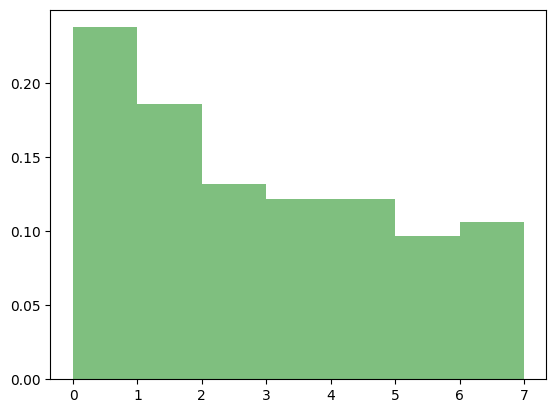

In [1162]:
plt.subplot()
n, bins, patches = plt.hist(dmag/10, bins=np.arange(0, 7.0001, 1),
                           density=True,
                           color='green', alpha=0.5)

def gamm(x, a, b):
    return scipy.stats.gamma(a, 1/beta).pdf(x)

popt, pcov = curve_fit(gamm, bins[0:-1]+0.5, n, p0=[alpha, beta])
xdata = np.arange(0, 7.0001, 0.01)


plt.plot(xdata, gamm(xdata, *popt), 'k', ls='dashed')

In [ ]:
import scipy.stats as stats
import xarray as xr

In [1168]:
pm.Discrete

pymc.distributions.distribution.Discrete

In [1161]:
model = pm.Model()

with model: 
    # alpha
    alpha = pm.Deterministic('alpha', lam=7.44474615e-01)
    # beta
    beta = pm.Deterministic('beta', lam=4.56219939e-08)
    g = pm.Gamma('g', alpha=alpha, beta=beta, observed=n)
    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 34 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


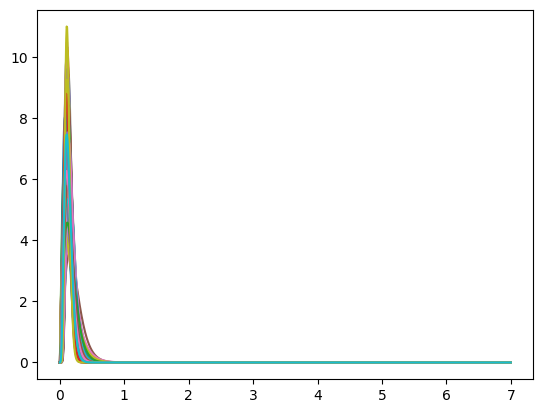

In [1159]:
xrange = xr.DataArray(np.linspace(0, 7, 1000), dims="x")
xr.apply_ufunc(
    lambda alpha, beta, x: stats.gamma(a=alpha, scale=1/beta).pdf(x),
    trace.posterior["alpha"], 
    trace.posterior["beta"], 
    xrange
)

# get random subset of the posterior
rng = np.random.default_rng()
idx = rng.choice(trace.posterior.alpha.size, 200)
post = trace.posterior.stack(sample=("chain", "draw")).isel(sample=idx)
pdfs = xr.apply_ufunc(
    lambda alpha, beta, x: stats.gamma(a=alpha, scale=1/beta).pdf(x),
    post["alpha"], post["beta"], xrange,
)
# plot results, for proper plotting, "x" dim must be the first
plt.plot(xrange, pdfs.transpose("x", ...));

In [1149]:
gamm(xdata, *popt), popt

(0.8527027876475088, array([7.44474615e-01, 4.56219939e-08, 8.52702759e-01]))

In [1154]:
scipy.stats.gamma.pdf(7.44474615e-01, 4.56219939e-08)

2.910738274649418e-08

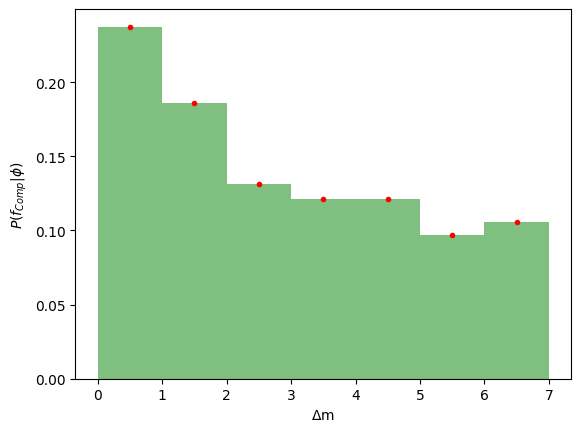

In [1179]:
plt.subplot()
n, bins, patches = plt.hist(dmag/10, bins=np.arange(0, 7.0001, 1.),
                           density=True, log=False,
                           color='green', alpha=0.5)
plt.xlabel('$\Delta$m')
plt.ylabel('$P(f_{Comp}|\phi)$')
#plt.ylabel('$N_{Comp}$')

plt.plot(bins[0:-1]+0.5, n, '.r')
def parab_fit(x, a, b, c, d):
    return d*x**3+a*x**2 + b*x + c
def tan_fit(x, k, w, x0, y0):
    return k * np.tan(w*(x0-x)) + y0
def gamm(x, a, b, c):
    return scipy.stats.gamma.pdf(a, b)+c

popt, pcov = curve_fit(gamm, bins[0:-1]+0.5, n, 
                       p0=[0.5, 0.1,1])
xdata = np.arange(0, 7.0001, 0.01)

#plt.plot(np.array([]), (n[2]-n[0])/2)

#plt.plot(xdata, scipy.stats.gamma.pdf(a, b)), 'k', ls='dashed')
#plt.plot(bins[0:-1]+0.5, n/np.sum(n), '+b')
#plt.plot(bins_cumul[0:-1]+0.25, 
#         np.flip(np.flip(n_cumul)-np.flip(np.append(0, n_cumul[0:-1]))),
#         '+b', ms=6)
         

In [997]:
O_cand = np.pi*(1000**2 -  100**2)
O_cont = np.pi*(5000**2 - 2000**2)

#N_cand and N_comp are total number of companions

In [976]:
math.factorial([5, 1])

120

In [1004]:
P_comp = (sig_los*O_cand)**(N_cand-N_comp) / \
             math.factorial(N_cand-N_comp) * \
                np.exp**(-(sig_los*O_cand))
P_Slos = (sig_los*O_cont)**N_cont        / \
             math.factorial(N_cont)        * \
                np.exp**(-(sig_los*O_cont))



NameError: name 'sig_los' is not defined

In [1015]:
with pm.Model() as model:
    bias = pm.Normal("beta[0]", mu=0, sigma=0.1)
    beta_recent = pm.Normal("beta[1]", mu=1, sigma=0.1)
    rho = [bias, beta_recent]
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    f = pm.AR("f", rho, sigma=sigma, constant=True, shape=T + F)

    lam = pm.TruncatedNormal("lam", mu=0, sigma=0.1, lower=-1, upper=1)

    y_past = GenPoisson("y_past", theta=tt.exp(f[:T]), lam=lam, observed=y_tr)
    
with model:
    trace = pm.sample(
        5000,
        tune=2000,
        target_accept=0.99,
        max_treedepth=15,
        chains=2,
        cores=1,
        init="adapt_diag",
        random_seed=42,
    )

NameError: name 'T' is not defined

In [1107]:
with pm.Model() as model:
    #prob = pm.Interpolated('hist', bins[0:-1]+0.5, n)
    prob = pm.Gamma('hist')
    #xdata = np.arange(0, 7.4, 0.5)
    #prob    = scipy.stats.gamma.pdf(xdata, *popt)
    trace_c = pm.sample(100, chains=8)
#P_fphi = parab_fit(xdata, *popt) #shape (7,) for dm intervals: 0-1, 1-2, ..., 6-7

ValueError: Incompatible parameterization. Either use alpha and beta, or mu and sigma to specify distribution.

/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_93443/1297842037.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rvs)


<Axes: ylabel='Density'>

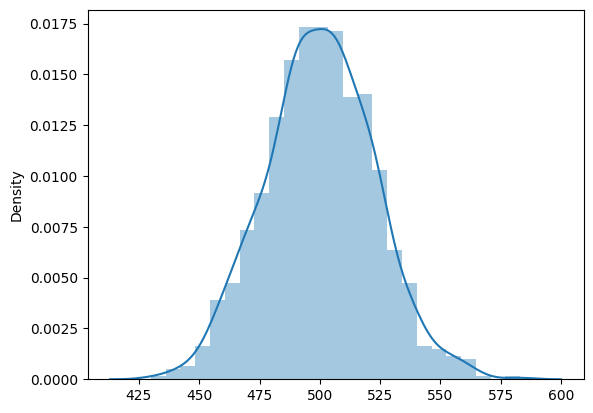

In [42]:
dist = scipy.stats.poisson(mu=500)
rvs = dist.rvs(1000)
import seaborn as sns
sns.distplot(rvs)

In [1104]:
with model:
    forecasts = pm.sample_posterior_predictive(trace_c, 
                                               var_names=['hist'],
                                               random_seed=42)
    #forecasts['hist']

Sampling: [hist]


In [1105]:
Pf_draws = forecasts.posterior_predictive.data_vars['hist'].values

In [1045]:
Pf_draws

array([[6.16395677, 6.1402588 , 5.99738445, ..., 5.44206879, 5.65571219,
        4.00085334],
       [5.45481225, 2.57931971, 2.65102683, ..., 6.24435259, 6.1449641 ,
        6.05053616],
       [3.94501329, 3.10173421, 6.00640509, ..., 5.04702981, 5.91852869,
        3.1585423 ],
       [3.63262492, 5.13805567, 3.25536785, ..., 3.51732943, 3.65152223,
        4.15278287]])

(array([0.       , 0.1345125, 0.2547375, 0.3593   , 0.4470875, 0.52565  ,
        0.6005   , 0.6726   , 0.7449625, 0.815075 , 0.8768625, 0.9377   ,
        1.       , 1.       ]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. ]),
 <BarContainer object of 14 artists>)

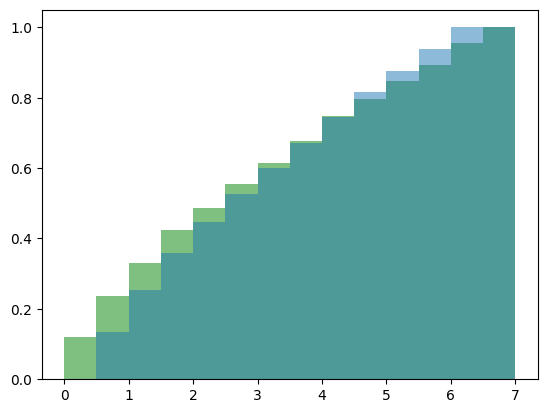

In [1106]:
plt.subplots()
plt.hist(dmag/10, bins=np.arange(0, 7.0001, 0.5),
                           density=True, cumulative=True,
                           color='green', alpha=0.5)
plt.hist(Pf_draws.flatten(), bins=np.arange(0, 7.0001, 0.5), alpha=0.5,
                           density=True, cumulative=True,)

In [ ]:
result = integrate.quad(lambda x: P_comp*P_Slos*P_fphi, 0, 1)

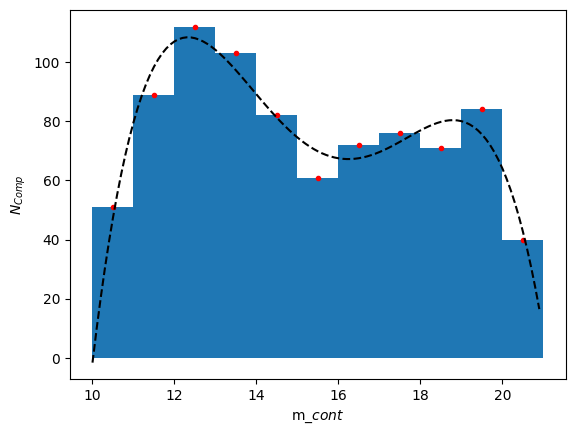

In [876]:
plt.subplot()
n_c, bins_c, patches_c = plt.hist(cmag[cmag>0.], bins=np.arange(10, 22., 1))#,
                          # cumulative=True)
plt.xlabel('m_${cont}$')
plt.ylabel('$N_{Comp}$')

plt.plot(bins_c[0:-1]+0.5, n_c, '.r')
def parab_fit(x, a, b, c, d,e):
    return e*x**4+d*x**3+a*x**2 + b*x + c
def tan_fit(x, k, w, x0, y0):
    return k * np.tan(w*(x0-x)) + y0

popt, pcov = curve_fit(parab_fit, bins_c[0:-1]+0.5, n_c, 
                       p0=[1,1,1, 1,1])
xdata = np.arange(10, 21., 0.1)

#plt.plot(np.array([]), (n[2]-n[0])/2)

plt.plot(xdata, parab_fit(xdata, *popt), 'k', ls='dashed')


In [852]:
n_c/np.sum(n_c)

array([0.06064209, 0.1058264 , 0.13317479, 0.12247325, 0.09750297,
       0.0725327 , 0.08561237, 0.09036861, 0.08442331, 0.09988109,
       0.04756243])

In [878]:
f_c = scipy.interpolate.interp1d(bins_c[0:-1]+0.5,n_c, bounds_error=False,
                               fill_value=0)
XX_c = np.linspace(10, 21, 1000)

with pm.Model() as model:
    pm.Interpolated('hist', bins_c[0:-1]+0.5, n_c)
    #pm.Interpolated('interp1d', XX_c, f_c(XX_c))
    trace_c = pm.sample(1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [hist, interp1d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 344 divergences after tuning. Increase `target_accept` or reparameterize.


In [879]:
trace_c

Inference data with groups:
	> posterior
	> sample_stats

In [873]:
f = scipy.interpolate.interp1d(bins[0:-1]+0.5,n, bounds_error=False,
                               fill_value=0)
XX = np.linspace(0, 7, 1000)

with pm.Model() as model:
    pm.Interpolated('hist', bins[0:-1]+0.5, n)
    pm.Interpolated('interp1d', XX, f(XX))
    trace = pm.sample(1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [hist, interp1d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 1082 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'hist'}>,
        <Axes: title={'center': 'hist'}>],
       [<Axes: title={'center': 'interp1d'}>,
        <Axes: title={'center': 'interp1d'}>]], dtype=object)

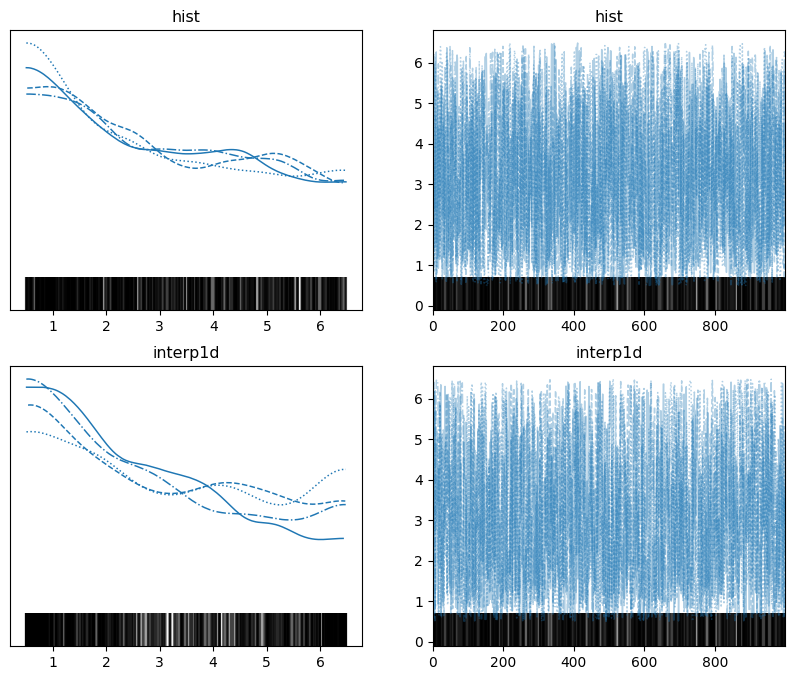

In [874]:
az.plot_trace(trace, figsize=(10,8), rug=False)

array([[<Axes: title={'center': 'hist'}>,
        <Axes: title={'center': 'hist'}>],
       [<Axes: title={'center': 'interp1d'}>,
        <Axes: title={'center': 'interp1d'}>]], dtype=object)

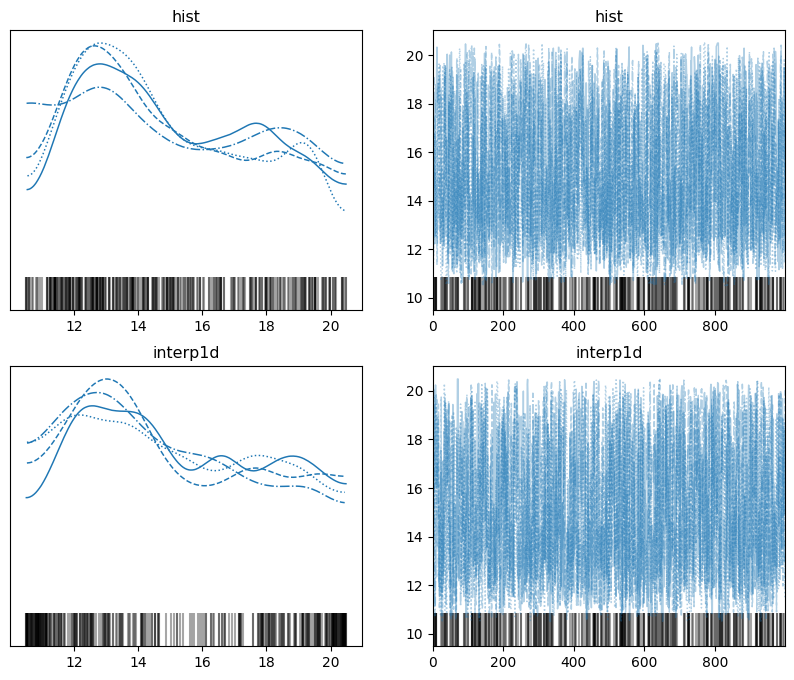

In [847]:
az.plot_trace(trace_c, figsize=(10,8), rug=False)

In [848]:
histog_c = trace_c.posterior.data_vars['hist'].data
int_histog_c = trace_c.posterior.data_vars['interp1d'].data

In [842]:
histog = trace.posterior.data_vars['hist'].data
int_histog = trace.posterior.data_vars['interp1d'].data

<Axes: >

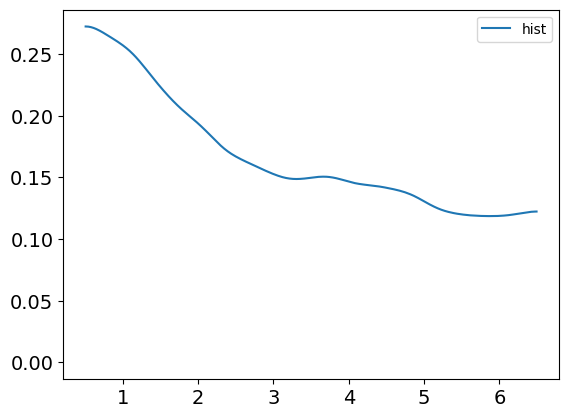

In [809]:
az.plot_dist(histog, label='hist')
#az.plot_dist(int_histog, color='r', label='inte')

<Axes: >

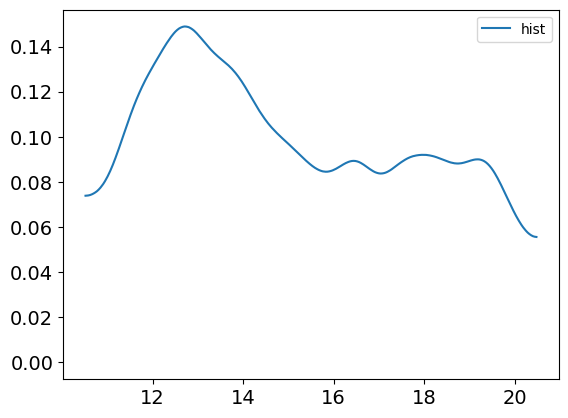

In [849]:
az.plot_dist(histog_c, label='hist')
#az.plot_dist(int_histog, color='r', label='inte')

In [808]:
histog.shape

(4, 10000)

In [717]:
nsample = 100

with pm.Model() as model:
    a = pm.Uniform('a')
    b = pm.Uniform('b')
    c = pm.Uniform('c')
    model_error = pm.HalfNormal('error', 10)
    x = bins[0:-1]+0.5
    likelihood  = pm.Normal('N', mu=a*x**2+b*x+c,
                      sigma=model_error, observed=n)
    # Inference
    start = pm.find_MAP() # Find starting value by optimization
    step  = pm.NUTS() 
    # Instantiate MCMC sampling algorithm
    trace = pm.sample(nsample) # run with 4 cores


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, c, error]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'error'}>,
        <Axes: title={'center': 'error'}>]], dtype=object)

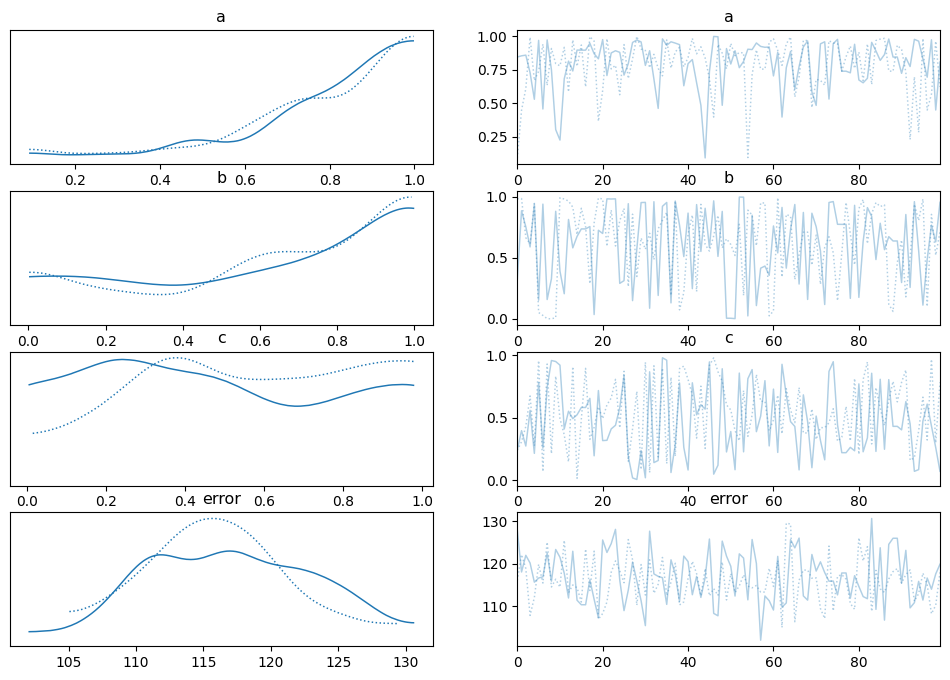

In [712]:

az.plot_trace(trace, )

In [751]:
with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    a = pm.Uniform('a')
    b = pm.Uniform('b')
    c = pm.Uniform('c')
    model_error = pm.HalfNormal('error', 10)
    x = bins[0:-1]+0.5
    likelihood  = a*x**2+b*x+c

In [754]:
start

{'a_interval__': array(221.81006772),
 'b_interval__': array(45.83377917),
 'c_interval__': array(11.40858862),
 'error_log__': array(4.74999636),
 'a': array(1.),
 'b': array(1.),
 'c': array(0.9999889),
 'error': array(115.58386393)}

In [752]:
pm.fit(n=1000, model=model)

Finished [100%]: Average Loss = 1.4557


AttributeError: 'TensorVariable' object has no attribute 'hist'

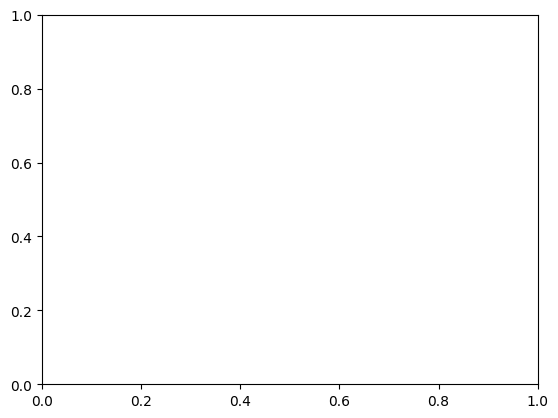

In [753]:
plt.subplots()
plt.hist(likelihood.hist)

In [742]:
try:
    import bambi as bmb
except ImportError:
    !{sys.executable} -m pip install --upgrade bambi
    import bambi as bmb

In [744]:
x_arr = np.arange(1, 8., 1)
data = pd.DataFrame(dict(x=bins[0:-1]+0.5, y=n))
#model = bmb.Model("parab_fit", data)
idata = model.fit(draws=1000)

AttributeError: 'Model' object has no attribute 'fit'

In [718]:
hist_N, bins_N = np.histogram(trace['N'], normed=True)

KeyError: 'N'

In [732]:
fig = plt.figure(figsize=(10, 10))
hist_N, bins_N = np.histogram(np.array(trace.observed_data['N'].values))

<Figure size 1000x1000 with 0 Axes>

In [734]:
trace.observed_data

<xarray.Dataset>
Dimensions:  (N_dim_0: 7)
Coordinates:
  * N_dim_0  (N_dim_0) int64 0 1 2 3 4 5 6
Data variables:
    N        (N_dim_0) float64 184.0 328.0 430.0 524.0 618.0 693.0 775.0
Attributes:
    created_at:                 2023-07-28T22:11:59.336661
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.4.0

In [631]:
help(pm.Binomial.dist)

Help on method dist in module pymc.distributions.discrete:

dist(n, p=None, logit_p=None, *args, **kwargs) method of pymc.distributions.distribution.DistributionMeta instance
    Creates a tensor variable corresponding to the `cls` distribution.
    
    Parameters
    ----------
    dist_params : array-like
        The inputs to the `RandomVariable` `Op`.
    shape : int, tuple, Variable, optional
        A tuple of sizes for each dimension of the new RV.
    **kwargs
        Keyword arguments that will be forwarded to the PyTensor RV Op.
        Most prominently: ``size`` or ``dtype``.
    
    Returns
    -------
    rv : TensorVariable
        The created random variable tensor.



In [646]:
y = pm.Binomial.dist(n=10, p=0.5)

In [647]:
pm.logp(y, 15)

Check{n >= 0, 0 <= p <= 1}.0

In [657]:
pm.draw(y)

array(6)

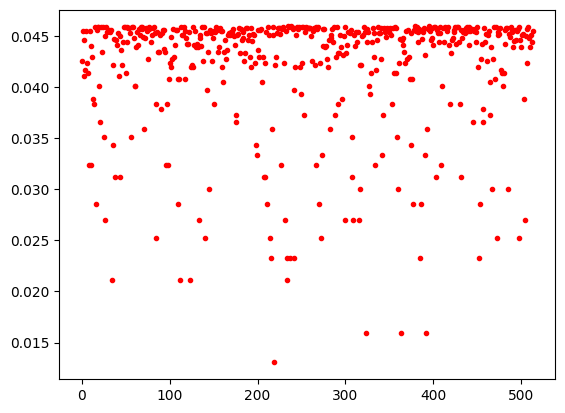

In [563]:
plt.subplot()
plt.plot(R, '.r')

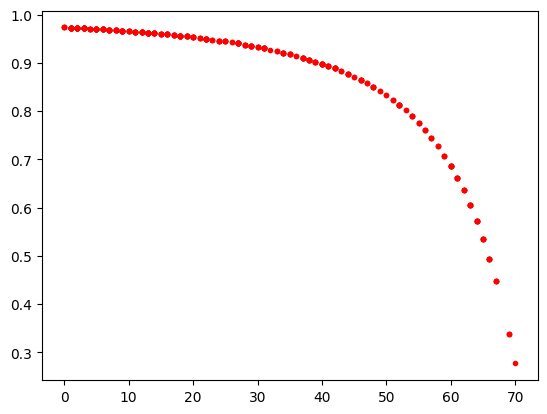

In [564]:
plt.subplot()
plt.plot(dmag, R/(1000**2-100**2)*(5000**2-2000**2), '.r')

--------------


## Testing calculations with Guided Survey

In [490]:
def CF_G(ra_cat, dec_cat, m_cat, i_yso):
#ra_cat, dec_cat, m_cat, i_yso = ra_Dcat, dec_Dcat, m_Dcat, i_Dyso
    N_total = len(i_yso)
    N_cand, N_cont, N_comp = 0, 0, 0
    
    r1_comp = 100
    r2_comp = 1000
    r1_cont = 2000
    r2_cont = 5000
    
    def r_times_logistic_reg(x, m, s):
        w = x*1/(1+np.exp(-((x-m)/s)))
        return w
    
    
    #Making a catalog object using all sources
    c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
                  distance=420.*u.pc, frame='fk5')
   
    ra_yso  = ra_cat[i_yso]
    dec_yso = dec_cat[i_yso]
    m_yso   = m_cat[i_yso]
    
    i_tested = np.array([])

    R     = np.array([])
    R_unc = np.array([])
    N_cont_init = np.array([])
    N_cont_corr = np.array([])
    N_cont_prior_corr = np.array([])
    N_cont  = 0
    d_mag   = np.array([])
    dist    = np.array([])
    #fig, ax = plt.subplots()
    for i in range(N_total):
        #Making a catalog object using YSO
        c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=420.*u.pc, frame='fk5')
        sep_     = c2.separation(c1).arcsec*420.
        i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp))#&(m_cat>10.5))
        n_obj    = len(i_obj_)
        if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array
            
            i_prim, = np.where(m_sys==np.min(m_sys))
            i_comp, = np.where(m_sys!=np.min(m_sys))
            ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
            ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
            m_prim = m_sys[i_prim]
            c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=420.*u.pc, frame='fk5')
            c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=420.*u.pc, frame='fk5')
            sep_comp = c_comp.separation(c_prim).arcsec*420.
            
            #making a new cat obj with the dimmest objects in the system
            sep      = c2.separation(c_prim).arcsec*420.
            i_obj_,  = np.where((sep>=r1_comp)&(sep<=r2_comp))#&(m_cat>10.5))
            n_obj    = len(i_obj_)
            N_cand   = N_cand + n_obj
            
            i_cont,  = np.where((sep>=r1_cont)&(sep<=r2_cont))
        else:
            i_cont,  = np.where((sep_>=r1_cont)&(sep_<=r2_cont))
        
        N_cont_init = np.append(N_cont_init, len(i_cont))
        n_cont = 0
        if len(i_cont)>0:
            for j in range(len(i_cont)):
                delta_m = m_cat[i_cont[j]]-m_prim
                dm_ind  = int(np.abs(10*np.round(delta_m, 1)))
                if dm_ind>70:
                    mu_, sig_ = 0, 0
                    R_ = 0
                else:
                    mu_  = mu[dm_ind]
                    sig_ = sig[dm_ind]
                    I  = quad(r_times_logistic_reg, r1_comp, r2_comp, args=(mu_, sig_))
                    R_ = 2*np.pi * I[0] / (np.pi*(r2_cont**2 - r1_cont**2))
                    R  = np.append(R, R_)
                    d_mag=np.append(d_mag,dm_ind)
                    R_unc   = np.append(R_unc, I[1])
                    dist = np.append(dist, sep_[i_cont[j]])
                n_cont  = n_cont + R_
                
            N_cont_corr = np.append(N_cont_corr, n_cont)
            N_cont_prior_corr = np.append(N_cont_prior_corr, 
                                          len(i_cont)*
                                          (r2_comp**2-r1_comp**2)/(r2_cont**2-r1_cont**2))
            N_cont = N_cont + n_cont

        i_tested = np.append(i_tested, i_yso[i])
        i_tested = np.append(i_tested, i_obj_)
    N_comp   = N_cand - N_cont
        

    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.85, 5))
    #for i in range(len(dist)):
    #    ax.plot(dist[i], d_mag[i], '.', color=category_colors[int(1000*np.round(R[i], 3))])           
    #ax.plot(R, '.r')
    print('N_cand: ', N_cand)
    print('N_cont within 2000-5000 (before correction): ', np.sum(N_cont_prior_corr))
    print('N_cont within 2000-5000: ', np.sum(N_cont_corr))
    print('N_contaminants: ', np.sum(N_cont_init))
    print('N_comp: ', N_comp)
    print('CF ('+str(N_total)+'): ', N_comp/N_total)
    return d_mag, R, dist

In [480]:
guided =  Table.read('wfc3.txt', format='ascii')

In [481]:
catalog = guided[guided['wfc3m']!=-0.0]
catalog

ra,dec,wfc3m,wfc3u,nic1.6m,nic1.6u,nic2.05m,nic2.05u,irtfm,irtfu,hops,separation,closesthops,4thnearest
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
88.737286,1.7155785,13.502162,0.041815419,0.0,0.0,0.0,0.0,10.042865,0.0069383709,3.0,0.0,3.0,226262.17
83.867269,-5.1705367,10.153605,0.047382092,0.0,0.0,0.0,0.0,8.5100002,0.0099999998,-1041.0,0.0,-1041.0,11024.07
83.867387,-5.1700753,13.109348,0.048968194,0.0,0.0,0.0,0.0,11.7,0.1,0.0,720.02943,-1041.0,0.0
83.856884,-5.1325495,10.777232,0.027959219,10.489038,0.001,10.214037,0.001,10.07,0.1,0.0,450.22175,71.0,0.0
83.856605,-5.1326541,18.24376,0.23583913,20.456038,0.0020000001,14.572037,0.0020000001,10.2,0.2,71.0,0.0,71.0,16048.257
83.856402,-5.1324409,12.709577,0.029863019,12.474038,0.0020000001,12.162037,0.0020000001,11.35,0.0033656652,0.0,445.27254,71.0,0.0
83.843163,-5.1275248,12.262151,0.030911366,0.0,0.0,0.0,0.0,8.3172455,0.003998179,-1053.0,0.0,-1053.0,18873.717
84.680734,-7.0263693,12.645921,0.033995372,0.0,0.0,0.0,0.0,10.0,0.1,0.0,302.028,-1131.0,0.0
84.680539,-7.0263264,13.060127,0.034622159,0.0,0.0,0.0,0.0,9.4700003,0.2,-1131.0,0.0,-1131.0,18026.508


In [482]:
#Pre-MS hops<0
#Protostar hops>0
#
c_prems = catalog[(catalog['hops']<0)]
c_proto = catalog[(catalog['hops']>0)]
c_protocand = catalog[(catalog['separation']<1000.)&(catalog['separation']>100.)&(catalog['closesthops']>0.)
        &(catalog['hops']==0.)]
c_premscand = catalog[(catalog['hops']==0)&(catalog['separation']<1000)&(catalog['separation']>100)&(catalog['closesthops']<0.)]

c_yso = vstack([c_prems, c_proto, c_protocand, c_premscand])


In [483]:
len(catalog), len(c_proto), len(c_prems), len(c_protocand), len(c_premscand)

(4984, 129, 197, 20, 28)

In [484]:
i_Gprems, = np.where(catalog['hops']<0)
i_Gproto, = np.where((catalog['hops']>0))
i_Gyso,  = np.where(((catalog['hops']==0)&(catalog['separation']<1000)&(catalog['separation']>100)&
         (catalog['closesthops']<0.))|(catalog['hops']<0)|(catalog['hops']>0))

In [485]:
ra_G  = catalog['ra']
dec_G = catalog['dec']
m_G   = catalog['wfc3m']

In [491]:
deltam, R, separations = CF_G(ra_G, dec_G, m_G, i_Gproto)

N_cand:  18
N_cont within 2000-5000 (before correction):  4.525714285714286
N_cont within 2000-5000:  1.8447627463364253
N_contaminants:  96.0
N_comp:  16.155237253663575
CF (129):  0.1252343973152215


In [492]:
deltam, R, separations = CF_G(ra_G, dec_G, m_G, i_Gprems)

N_cand:  28
N_cont within 2000-5000 (before correction):  7.731428571428572
N_cont within 2000-5000:  2.4201071769552085
N_contaminants:  164.0
N_comp:  25.57989282304479
CF (197):  0.12984717169058269


*NGC 2024 calculation*

In [493]:
#c = catalog
ra, dec, m, i_yso = ra_G, dec_G, m_G, i_Gprems #np.append(i_prems, i_proto)

c2 = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, distance=420*u.pc, frame='fk5')
   
#if objtype == 0:
obj_ra = ra[i_yso]
obj_dec = dec[i_yso]
#if objtype == 1:
#    obj_ra = c_prems['ra']
#    obj_dec = c_prems['dec']
N_total = len(obj_ra)
N_cand, N_cont = 0, 0
r1_comp = 100
r2_comp = 500
r1_cont = 2000
r2_cont = 5000
for i in range(len(obj_ra)):
    c1 = SkyCoord(ra=obj_ra[i]*u.degree, dec=obj_dec[i]*u.degree, distance=420*u.pc, frame='fk5')
    
    sep_ = c2.separation(c1).arcsec*420.
    
    i_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp))
    i_cont,  = np.where((sep_>=r1_cont)&(sep_<=r2_cont))
    if len(i_)>0:
        #p += 1
        N_cand = N_cand + len(i_)
        
    if len(i_cont)>0:
        N_cont = N_cont + len(i_cont)
        
#if objtype == 0:
#    objname = 'protostars  '
#elif objtype == 1:
#    objname = 'pre-ms stars'
objname = 'all'
    
k      = 1
O_comp = k*(r2_comp**2 - r1_comp**2)
O_cont = k*(r2_cont**2 - r1_cont**2)
    
N_pcont = N_cont*(O_comp/O_cont)
N_comp  = N_cand - N_pcont

print('* No. of '+objname+'                               = '+ str(N_total))
print('* No. of candidate companions                       = '+ str(N_cand))
print('* No. of projected contaminants between ('+ str(r1_cont) + '-'+ str(r2_cont) +') = '+ 
      str(np.round(N_pcont, 2))+' (N of Cont. = '+str(N_cont)+')')
print('* No. of companions between ('+ str(r1_comp) + '-'+ str(r2_comp) +')               = '+ 
      str(np.round(N_comp,  2)))
print('* Companion Fraction (CF)                           = '+ 
      str(np.round(N_comp/N_total*100,  2))+'%')  

* No. of all                               = 197
* No. of candidate companions                       = 17
* No. of projected contaminants between (2000-5000) = 1.87 (N of Cont. = 164)
* No. of companions between (100-500)               = 15.13
* Companion Fraction (CF)                           = 7.68%


## CF in selected regions

In [494]:
bubbles = np.array(['polygon,84.0937996,-4.6643728,84.0361250,-4.6371756,83.8813337,-4.6251247,83.7168909,-4.6596243,83.6815070,-4.7362616,83.7014955,-4.8128984,83.7445637,-4.8956610,83.7907169,-4.9309070,83.8922603,-4.9630711,83.9999538,-4.9599687,84.1385083,-4.9290058,84.2122792,-4.8932506,84.2354275,-4.8155203,84.1909571,-4.7429606,84.1514821,-4.7036636',
                    'polygon,83.9552846,-5.2400872,83.9277117,-5.2234286,83.8904312,-5.2229525,83.8894500,-5.2224644,83.8557738,-5.2330406,83.8445725,-5.2516531,83.8435683,-5.2525444,83.8427167,-5.2539578,83.8374192,-5.2638636,83.8379479,-5.2908486,83.8404883,-5.3093069,83.8678763,-5.3245369,83.9081058,-5.3303844,83.9283888,-5.3323408,83.9665450,-5.3285953,83.9900500,-5.3197675,84.0006071,-5.3045022,83.9995825,-5.2943289,83.9982150,-5.2763558,83.9879917,-5.2614389',
                    'polygon,83.9477946,-5.3589897,83.7261733,-5.2684994,83.5576179,-5.3591722,83.4232479,-5.4257900,83.3958350,-5.5769378,83.4413525,-5.7311178,83.5021133,-5.8036764,83.7327904,-5.8511961,83.8615088,-5.8313106,83.9657992,-5.7761033,84.0234688,-5.6900097,84.0478379,-5.5708197,84.0078788,-5.4671031'])

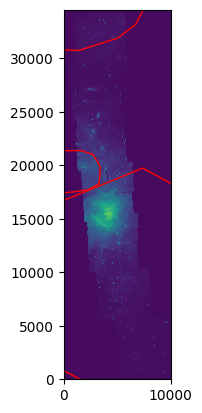

In [495]:
fig, ax = plt.subplots()
stretch = AsinhStretch(a=0.005)
norm = ImageNormalize(stretch=stretch, vmin=-1*np.abs(np.min(im))*0.1, vmax=np.max(im)*0.6)
ax.imshow(im, origin='lower', norm=norm)
borders = np.array([])
for j in range(len(bubbles)):
    region = []
    coords = bubbles[j].split(',')[1::]
    for i in range(int(len(coords)/2)):
        #coords[i]
        ra, dec = float(coords[2*i]), float(coords[2*i+1])
        x, y = wcs.all_world2pix(ra, dec, 0)
        region.append((x, y))
    border = patches.Polygon(region, edgecolor='red', facecolor='none')
    ax.add_patch(border)
    borders = np.append(borders, border)

#### NGC 1977 extended 

In [496]:
i_1 = np.array([])
path = borders[0].get_path()
for i in range(len(ra_f2)):
    x_1, y_1 = wcs.all_world2pix(ra_f2[i], dec_f2[i], 0)
    if path.contains_point((x_1, y_1)):
        if ~np.isin(i, i_1):
            i_1 = np.append(i_1, i)
i_1 = np.array(i_1, int)

All YSO

In [567]:
#Contaminants - all survey objects
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_1[np.isin(i_1, i_yso)])

N_cand:  1
N_cont within 200-5000 (before correction):  1.5557142857142858
N_cont within 200-5000:  1.0297225615614976
N_contaminants:  33.0
N_comp:  -0.02972256156149755
CF (28):  -0.0010615200557677698


Protostars

In [568]:
#Contaminants - all survey objects
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_1[np.isin(i_1, i_proto)])

N_cand:  0
N_cont within 200-5000 (before correction):  0.0
N_cont within 200-5000:  0.0
N_contaminants:  0.0
N_comp:  0
CF (1):  0.0


Pre-Main Sequence Stars

In [569]:
#Contaminants - all survey objects
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_1[np.isin(i_1, i_prems)])

N_cand:  1
N_cont within 200-5000 (before correction):  1.5557142857142858
N_cont within 200-5000:  1.0297225615614976
N_contaminants:  33.0
N_comp:  -0.02972256156149755
CF (27):  -0.0011008356133887982


#### M43 

In [500]:
i_2 = np.array([])
path = borders[1].get_path()
for i in range(len(ra_f2)):
    x_2, y_2 = wcs.all_world2pix(ra_f2[i], dec_f2[i], 0)
    if path.contains_point((x_2, y_2)):
        if ~np.isin(i, i_2):
            i_2 = np.append(i_2, i)
i_2 = np.array(i_2, int)

In [570]:
#Contaminants - objects only in the selected environment
dmag, R, dist = CF(ra_f2[i_2], dec_f2[i_2], m_f2[i_2], np.where(np.isin(i_2, i_yso))[0])

N_cand:  4
N_cont within 200-5000 (before correction):  2.3571428571428568
N_cont within 200-5000:  1.6165751320459392
N_contaminants:  50.0
N_comp:  2.3834248679540613
CF (42):  0.056748211141763365


All YSO

In [571]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_yso[np.isin(i_yso, i_2)])

N_cand:  4
N_cont within 200-5000 (before correction):  2.451428571428571
N_cont within 200-5000:  1.7039138900066586
N_contaminants:  52.0
N_comp:  2.2960861099933414
CF (42):  0.054668716904603364


Note: No protostars

Pre-Main Sequence Stars

In [572]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_prems[np.isin(i_prems, i_2)])

N_cand:  4
N_cont within 200-5000 (before correction):  2.451428571428571
N_cont within 200-5000:  1.7039138900066586
N_contaminants:  52.0
N_comp:  2.2960861099933414
CF (42):  0.054668716904603364


#### Orion nebula extended 

In [576]:
i_3 = np.array([])
path = borders[2].get_path()
for i in range(len(ra_f2)):
    x_3, y_3 = wcs.all_world2pix(ra_f2[i], dec_f2[i], 0)
    if path.contains_point((x_3, y_3))&(m_f2[i]>12.):
        if ~np.isin(i, i_3):
            i_3 = np.append(i_3, i)
i_3 = np.array(i_3, int)

All YSO

In [573]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_yso[np.isin(i_yso, i_3)])

N_cand:  63
N_cont within 200-5000 (before correction):  28.427142857142854
N_cont within 200-5000:  23.378750881665212
N_contaminants:  603.0
N_comp:  39.62124911833477
CF (422):  0.09388921592022456


Protostars

In [574]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_proto[np.isin(i_proto, i_3)])

N_cand:  5
N_cont within 200-5000 (before correction):  1.98
N_cont within 200-5000:  1.7539105168990095
N_contaminants:  42.0
N_comp:  3.2460894831009908
CF (32):  0.10144029634690596


In [580]:
#magnitudes >12. only
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_proto[np.isin(i_proto, i_3)])

N_cand:  4
N_cont within 200-5000 (before correction):  1.6971428571428573
N_cont within 200-5000:  1.545814370650403
N_contaminants:  36.0
N_comp:  2.454185629349597
CF (29):  0.08462709066722748


Pre-Main Sequence Stars

In [575]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_prems[np.isin(i_prems, i_3)])

N_cand:  58
N_cont within 200-5000 (before correction):  26.447142857142858
N_cont within 200-5000:  21.624840364766207
N_contaminants:  561.0
N_comp:  36.375159635233786
CF (390):  0.09326964009034304


In [577]:
#magnitudes >12. only
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_prems[np.isin(i_prems, i_3)])

N_cand:  38
N_cont within 200-5000 (before correction):  14.52
N_cont within 200-5000:  12.373106077049002
N_contaminants:  308.0
N_comp:  25.626893922950998
CF (223):  0.11491880682937668


In [578]:
len(m_f2), len(m_f2[m_f2>12])

(4038, 3428)